# Домашнее задание №7. Обработка видео

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
!pip install scikit-video==1.1.11
import skvideo.io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 32.7 MB/s 


### Задание

Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH.

Библиотеки: [Python, Tensorflow]



## План решения
[0. Загрузка и просмотр данных](#section_0)

[1. Подготовка пайплайна данных](#section_1)

[2. Построение и обучение модели 3D CNN](#section_2)
 
[3. Тестирование обученной модели](#section_3)

### 0. Загрузка и просмотр данных <a id='section_0'></a>

In [4]:
#скачиваем архивы с датасетами
!wget http://www.csc.kth.se/cvap/actions/walking.zip
!wget http://www.csc.kth.se/cvap/actions/jogging.zip
!wget http://www.csc.kth.se/cvap/actions/running.zip
!wget http://www.csc.kth.se/cvap/actions/boxing.zip
!wget http://www.csc.kth.se/cvap/actions/handwaving.zip
!wget http://www.csc.kth.se/cvap/actions/handclapping.zip

--2022-08-10 11:05:16--  http://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2022-08-10 11:05:17--  https://www.csc.kth.se/cvap/actions/walking.zip
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242442411 (231M) [application/zip]
Saving to: ‘walking.zip’

walking.zip         100%[===================>] 231.21M   603KB/s    in 6m 45s  

2022-08-10 11:12:03 (584 KB/s) - ‘walking.zip’ saved [242442411/242442411]

URL transformed to HTTPS due to an HSTS policy
--2022-08-10 11:12:03--  https://www.csc.kth.se/cvap/actions/jogging.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29

In [5]:
#распаковываем архивы
!unzip walking.zip -d walking > /dev/null
!unzip jogging.zip -d jogging > /dev/null
!unzip running.zip -d running > /dev/null
!unzip boxing.zip -d boxing > /dev/null
!unzip handwaving.zip -d handwaving > /dev/null
!unzip handclapping.zip -d handclapping > /dev/null

In [6]:
#удаляем архивы (чтобы освободить место на диске)
!rm walking.zip
!rm jogging.zip
!rm running.zip
!rm boxing.zip
!rm handwaving.zip
!rm handclapping.zip

In [7]:
#список классов
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

In [9]:
#составляем список (путь к видео, класс)
dataset_data = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
      dataset_data.append((fpath, cls))
print(f'Количество видеороликов: {len(dataset_data)}')

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping
Количество видеороликов: 599


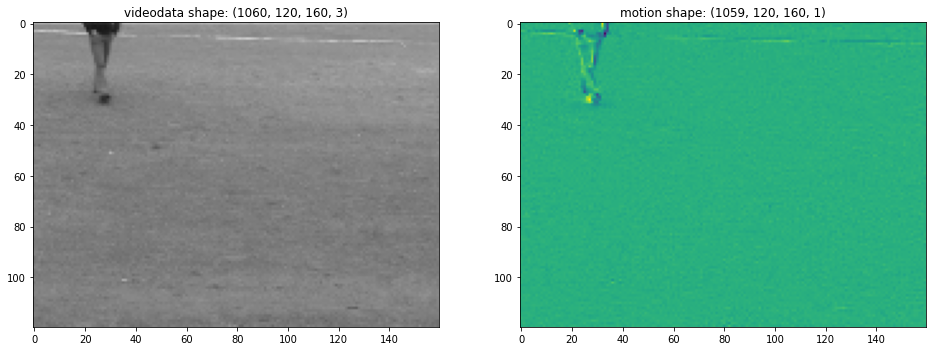

In [20]:
#визуализация данных
fig = plt.figure(figsize=(16, 8))
ax_1 = fig.add_subplot(1, 2, 1)
videodata = skvideo.io.vread(dataset_data[0][0])
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[50, ...])
plt.title(f'videodata shape: {videodata.shape}')
  
ax_2 = fig.add_subplot(1, 2, 2)
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
plt.imshow(motion[50, ..., 0])
plt.title(f'motion shape: {motion.shape}')
plt.show()

### 1. Подготовка пайплайна данных <a id='section_1'></a>

In [42]:
#создание тренировочного и тестового датасетов

NUM_TRAIN_ELEM = 500
NUM_FRAMES = 200
NUM_EPOCHS = 5
BATCH_SIZE = 2

random.shuffle(dataset_data)

def path_to_motion(video_class, NUM_FRAMES=200):
    videodata = skvideo.io.vread(video_class.numpy()[0].decode('UTF-8'), num_frames=NUM_FRAMES)
    videodata = videodata.astype(np.float32) / 255.
    motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
    return motion, classes.index(video_class.numpy()[1].decode('UTF-8'))

def set_shapes(motion, cl_idx):
      #TensorFlow после использования tf.py_function не может установить выходные размеры
      #Поэтому установим их вручную
    motion.set_shape((199, 120, 160, 1))
    cl_idx.set_shape([])
    return motion, cl_idx

#создание датасетов
train_ds = tf.data.Dataset.from_tensor_slices(dataset_data[:NUM_TRAIN_ELEM])
train_ds = train_ds.shuffle(buffer_size=len(train_ds))
train_ds = train_ds.map(lambda video_class: tf.py_function(func=path_to_motion,
                                                            inp=[video_class], 
                                                           Tout=[tf.float32, tf.uint8]))
train_ds = train_ds.map(lambda x, y: set_shapes(x, y))
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
print(f'Длина тренировочного датасета: {len(train_ds)}')

test_ds = tf.data.Dataset.from_tensor_slices(dataset_data[NUM_TRAIN_ELEM:])
test_ds = test_ds.map(lambda video_class: tf.py_function(func=path_to_motion,
                                                          inp=[video_class], 
                                                         Tout=[tf.float32, tf.uint8]))
test_ds = test_ds.map(lambda x, y: set_shapes(x, y))
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)
print(f'Длина тестового датасета: {len(test_ds)}')

Длина тренировочного датасета: 250
Длина тестового датасета: 49


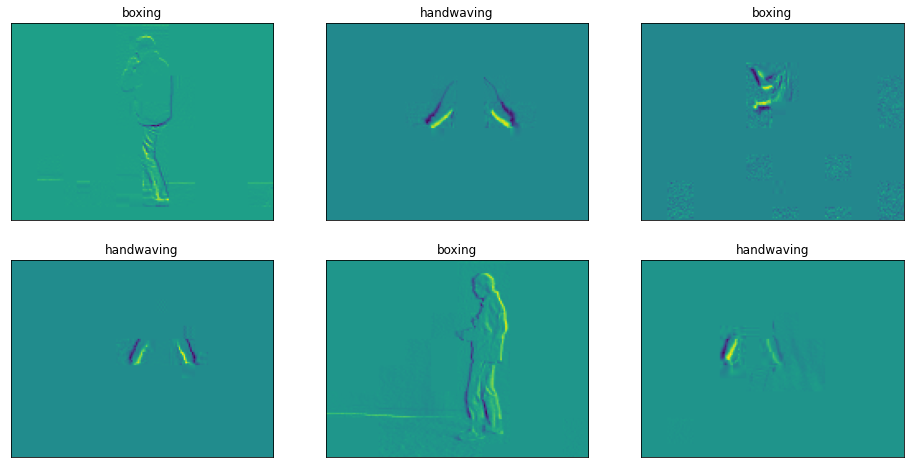

In [46]:
#визуализация тренировочного датасета
import tensorflow_datasets as tfds
ds_train_np = tfds.as_numpy(train_ds.take(6)) #tf.data.Dataset -> Iterator[Tree[np.array]] (преобразуем датасет в итератор)
fig = plt.figure(figsize=(16, 8))
j = 0
for motion, cl_idx in ds_train_np:
  ax = fig.add_subplot(2, 3, j+1)
  plt.imshow(motion[0][0][...,0])
  plt.xticks([]), plt.yticks([])
  plt.title(classes[cl_idx[0]])
  j += 1
plt.show()

### 2. Построение и обучение модели 3D CNN <a id='section_2'></a>

In [47]:
#создание модели
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None)
])

In [48]:
#компиляция модели
LEARNING_RATE = 0.001

model.compile(
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
         optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
          metrics = ['accuracy']
              )

In [49]:
#обучение модели
%%time
NUM_EPOCHS = 10

history = model.fit(
                     train_ds,
                     epochs=NUM_EPOCHS,
                     validation_data=test_ds
                    )

Epoch 1/10
250/250 [==============================] - 235s 939ms/step - loss: 1.5218 - accuracy: 0.3260 - val_loss: 0.9327 - val_accuracy: 0.5816
Epoch 2/10
250/250 [==============================] - 236s 943ms/step - loss: 0.8816 - accuracy: 0.6140 - val_loss: 0.7074 - val_accuracy: 0.7245
Epoch 3/10
250/250 [==============================] - 234s 937ms/step - loss: 0.5481 - accuracy: 0.7940 - val_loss: 0.4737 - val_accuracy: 0.7245
Epoch 4/10
250/250 [==============================] - 237s 948ms/step - loss: 0.3594 - accuracy: 0.8380 - val_loss: 0.2539 - val_accuracy: 0.8980
Epoch 5/10
250/250 [==============================] - 235s 938ms/step - loss: 0.2771 - accuracy: 0.8820 - val_loss: 0.1970 - val_accuracy: 0.8673
Epoch 6/10
250/250 [==============================] - 236s 944ms/step - loss: 0.2198 - accuracy: 0.9180 - val_loss: 0.2373 - val_accuracy: 0.8878
Epoch 7/10
250/250 [==============================] - 235s 941ms/step - loss: 0.2272 - accuracy: 0.9140 - val_loss: 0.1535 -

In [50]:
#оценка качества модели
model.evaluate(test_ds)

49/49 [==============================] - 37s 759ms/step - loss: 0.1316 - accuracy: 0.9184


[0.13161981105804443, 0.918367326259613]

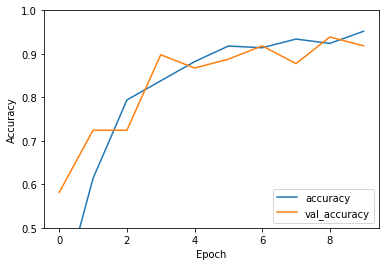

In [51]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

### 3. Тестирование обученной модели <a id='section_3'></a>

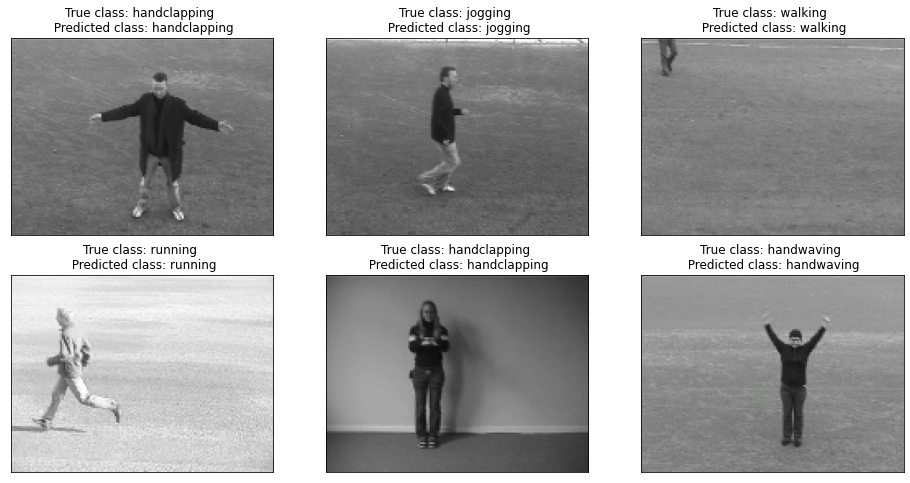

In [53]:
#тестирование модели на тестовом датасете
fpath_cls_true_list = random.sample(dataset_data[NUM_TRAIN_ELEM:], 6) #список из 6 элементов
fig = plt.figure(figsize=(16, 8))
for i in range(len(fpath_cls_true_list)):
  ax = fig.add_subplot(2, 3, i+1)
  videodata = skvideo.io.vread(fpath_cls_true_list[i][0])
  videodata = videodata.astype(np.float32) / 255.
  plt.imshow(videodata[30, ...])
  
  motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
  out = model(motion[None, ...])[0]
  cls_pred = np.argmax(out.numpy())
  plt.title(f'True class: {fpath_cls_true_list[i][1]} \n Predicted class: {classes[cls_pred]}')
  plt.xticks([]), plt.yticks([])
plt.show()